In [1]:
from torch import nn
import torch
from sklearn.metrics import cohen_kappa_score, calinski_harabasz_score
from ica_benchmark.split.split import Splitter
from ica_benchmark.io.load import Dataset, OpenBMI_Dataset, BCI_IV_Comp_Dataset
from pathlib import Path
from sklearn.model_selection import KFold

bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')

dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)


In [2]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [3]:
from collections import OrderedDict
from torchsummary import summary

# https://gist.github.com/bdsaglam/84b1e1ba848381848ac0a308bfe0d84c
# class SeparableConv2d(nn.Module):

#     def __init__(self, in_channels, out_channels, kernel_size, bias=True):
#         super(SeparableConv2d, self).__init__()

#         self.depthwise = nn.Conv2d(
#             in_channels,
#             in_channels,
#             kernel_size=kernel_size,
#             groups=in_channels,
#             bias=bias,
#             padding="same"
#         )
#         self.pointwise = nn.Conv2d(
#             in_channels,
#             out_channels, 
#             kernel_size=1,
#             bias=bias
#         )

#     def forward(self, x):
#         out = self.depthwise(x)
#         out = self.pointwise(out)
#         return out

# class SeparableConv2d(nn.Module):
#     def __init__(self, 
#                  in_channels,
#                  out_channels,
#                  kernel_size=3,
#                  stride=1,
#                  padding=0,
#                  dilation=1,
#                  bias=True,
#                  padding_mode='zeros',
#                  depth_multiplier=2,
#         ):
#         super(SeparableConv2d, self).__init__()
        
#         intermediate_channels = in_channels * depth_multiplier
#         self.spatial_conv = nn.Conv2d(
#              in_channels=in_channels,
#              out_channels=intermediate_channels,
#              kernel_size=kernel_size,
#              stride=stride,
#              padding=padding,
#              dilation=dilation,
#              groups=in_channels,
#              bias=bias,
#              padding_mode=padding_mode
#         )
#         self.point_conv = torch.nn.Conv2d(
#              in_channels=intermediate_channels,
#              out_channels=out_channels,
#              kernel_size=1,
#              stride=1,
#              padding=0,
#              dilation=1,
#              bias=bias,
#              padding_mode=padding_mode,
#         )
    
#     def forward(self, x):
#         return self.point_conv(self.spatial_conv(x))
    
class SeparableConv2d(nn.Module):
    def __init__(self, 
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 dilation=1,
                 bias=False,
                 padding="same",
                 padding_mode='zeros',
                 depth_multiplier=1,
        ):
        super(SeparableConv2d, self).__init__()
        # 16 * D * F1
        self.depthwise_layer = nn.Conv2d(
            in_channels, 
            depth_multiplier * in_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            dilation=1,
            stride=1,
            padding=padding,
            padding_mode=padding_mode,
            bias=bias
        )
        # F2 * D * F1
        self.pointwise_layer = nn.Conv2d(
            depth_multiplier * in_channels,
            out_channels,
            kernel_size=(1, 1),
            groups=1,
            dilation=1,
            stride=1,
            padding=padding,
            padding_mode=padding_mode,
            bias=bias
        )

    def forward(self, x):
        depthwise_output = self.depthwise_layer(x)
        pointwise_output = self.pointwise_layer(depthwise_output)
        return pointwise_output

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    
    def forward(self, x):
        return x.reshape(self.shape)

class ExpandDims(nn.Module):
    def __init__(self, dim=0):
        super(ExpandDims, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        if x.ndim == 2:
            # For C, T
            x = x.unsqueeze(0).unsqueeze(0)
        elif x.ndim == 3:
            # For N, C, T
            x = x.unsqueeze(1)
        return x

    
class EEGNet(nn.Module):
    
    def apply_max_norm(self, weights, max_value=1., eps=1e-5, dim=2):
        norms = self.norm(weights, dim=dim)
        desired = torch.clamp(norms, 0, max_value)
        new_weights = weights * (desired / (eps + norms))
        with torch.no_grad():
            weights.copy_(new_weights)
    
    def norm(self, filter_weights, dim=2):
#         filter_weights = self.depthwiseconv2d.weight
        norms = torch.norm(filter_weights, dim=dim, p=2, keepdim=True)
        return norms.mean()
    
    def __init__(self, n_channels, n_classes, length, *, f1=4, d=2, f2=8, p=.5, spatial_filter=True):
        super(EEGNet, self).__init__()
        self.f1 = f1
        self.d = d
        self.f2 = f2
        self.p = p
        self.length = length
        
        n_classes = 1 if (n_classes <= 2) else n_classes
        
        self.depthwiseconv2d = nn.Conv2d(f1, d * f1, (n_channels, 1), groups=f1, padding="valid", bias=False)
        self.first_block_top = nn.Sequential(
            OrderedDict(
                conv2d=nn.Conv2d(1, f1, (1, 64), padding="same", bias=False),
                batchnorm=nn.BatchNorm2d(f1, 1e-5),
                depthwiseconv2d=self.depthwiseconv2d
            )
        )
        
        self.first_block_bottom = nn.Sequential(
            OrderedDict(
                batchnorm=nn.BatchNorm2d(f1 * d, 1e-5),
                activation=nn.ELU(),
                avgpool2d=nn.AvgPool2d((1, 4), 4),
                dropout=nn.Dropout(p),
            )
        )
        
        self.second_block = nn.Sequential(
            OrderedDict(
#             SeparableConv2d(f1 * d, f2, (1, 16), bias=False),
                separableconv2d=SeparableConv2d(
                    d * f1,
                    f2,
                    kernel_size=(1, 16),
                    bias=False,
                    padding="same",
                    depth_multiplier=1
                ),
                batchnorm=nn.BatchNorm2d(f2, 1e-5),
                activation=nn.ELU(),
                avgpool2d=nn.AvgPool2d((1, 8), 8),
                dropout=nn.Dropout(p),
            )
        )
        
        self.classifier = nn.Sequential(
            OrderedDict(
                flatten=nn.Flatten(),
                linear=nn.Linear(f2 * length // 32, n_classes),
                activation=nn.Sigmoid() if (n_classes == 1) else nn.Softmax(dim=1)
            )
        )
    
    def apply_constraints(self, max_filter_norm=1., max_clf_norm=.25):
        self.apply_max_norm(self.depthwiseconv2d.weight, dim=2, max_value=max_filter_norm)
        self.apply_max_norm(self.classifier[1].weight, dim=1, max_value=max_clf_norm)
    
    def forward(self, x):
        output = self.first_block_top(x)
        output = self.first_block_bottom(output)
        output = self.second_block(output)
        output = self.classifier(output)
        return output

f1 = 4
d = 2
f2 = 8
n_channels = 22
length = 256
n_classes = 4

shape = (1, n_channels, 256)
model = EEGNet(n_channels, n_classes, length, f1=f1, f2=f2, d=d).to("cpu").float()
r = model.forward(torch.rand(100, 1, n_channels, length))
print(r.shape)
# display(model)

summary(model, input_size=shape, device="cpu")


torch.Size([100, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


In [4]:
get_n_params(model)

924

In [5]:
expected_sizes = {
    "first_block_top.conv2d.weight": f1 * 64,
    "first_block_top.batchnorm.weight": f1,
    "first_block_top.first_block_top.bias": f1,
    "first_block_top.depthwiseconv2d.weight": n_channels * d * f1,
   
    "first_block_bottom.batchnorm.weight": f1 * d,
    "first_block_bottom.batchnorm.bias": f1 * d,
    
    "second_block.separableconv2d.depthwise_layer.weight": 16 * d * f1,
    "second_block.separableconv2d.pointwise_layer.weight": f2 * d * f1,
    "second_block.batchnorm.weight": f2,
    "second_block.batchnorm.bias": f2,
    
    "classifier.linear.weight": n_classes * f2 * length // 32,
    "classifier.linear.bias": n_classes,
}

sum(expected_sizes.values())

924

In [6]:
from math import prod

print("F1 =", model.f1)
print("F2 =", model.f2)
print("D =", model.d)
print()

total_params = 0
for name, params in model.named_parameters():
    shape = params.shape
    n_params = prod(shape)
    
    warn_msg = ""
    expected_size = None
    if name in expected_sizes:
        expected_size = expected_sizes[name]
        if expected_sizes[name] != n_params:
            warn_msg = "[WRONG]"
        
    print(warn_msg, name)
    print("\tShape:", " * ".join(map(str, shape)))
    print("\t# Params / Expected: {} / {}".format(n_params, expected_size))
    print()
    total_params += n_params
total_params

F1 = 4
F2 = 8
D = 2

 depthwiseconv2d.weight
	Shape: 8 * 1 * 22 * 1
	# Params / Expected: 176 / None

 first_block_top.conv2d.weight
	Shape: 4 * 1 * 1 * 64
	# Params / Expected: 256 / 256

 first_block_top.batchnorm.weight
	Shape: 4
	# Params / Expected: 4 / 4

 first_block_top.batchnorm.bias
	Shape: 4
	# Params / Expected: 4 / None

 first_block_bottom.batchnorm.weight
	Shape: 8
	# Params / Expected: 8 / 8

 first_block_bottom.batchnorm.bias
	Shape: 8
	# Params / Expected: 8 / 8

 second_block.separableconv2d.depthwise_layer.weight
	Shape: 8 * 1 * 1 * 16
	# Params / Expected: 128 / 128

 second_block.separableconv2d.pointwise_layer.weight
	Shape: 8 * 8 * 1 * 1
	# Params / Expected: 64 / 64

 second_block.batchnorm.weight
	Shape: 8
	# Params / Expected: 8 / 8

 second_block.batchnorm.bias
	Shape: 8
	# Params / Expected: 8 / 8

 classifier.linear.weight
	Shape: 4 * 64
	# Params / Expected: 256 / 256

 classifier.linear.bias
	Shape: 4
	# Params / Expected: 4 / 4



924

In [8]:

def copy_as_raw(raw, data):
    """Aux method."""
    # merge copied instance and picked data with sources
    data_ = data
#     assert data_.shape[1] == stop - start

    preloaded = raw.preload
    if preloaded:
        # get data and temporarily delete
        data = raw._data
        raw.preload = False
        del raw._data
    # copy and crop here so that things like annotations are adjusted
    out = raw.copy()

    out._data = data_
    out._first_samps = [out.first_samp]
    out._last_samps = [out.last_samp]
    out._filenames = [None]
    out.preload = True
    out._projector = None
    return out



In [35]:
from tqdm.notebook import tqdm
import numpy as np
import mne

# https://github.com/TNTLFreiburg/braindecode/blob/d9feb5c6cfcd203fa8daa79ccd3217712714f330/braindecode/mne_ext/signalproc.py#L75
def apply_raw(func, raw, verbose="WARNING"):
    """
    Apply function to data of `mne.io.RawArray`.
    
    Parameters
    ----------
    func: function
        Should accept 2d-array (channels x time) and return modified 2d-array
    raw: `mne.io.RawArray`
    verbose: bool
        Whether to log creation of new `mne.io.RawArray`.
    Returns
    -------
    transformed_set: Copy of `raw` with data transformed by given function.
    """
    new_data = func(raw.get_data())
    new_raw = copy_as_raw(raw, new_data)
    return new_raw


def exponential_standardize(data, start=1000, eps=1e-4, alpha=1e-3):
    # https://arxiv.org/pdf/1703.05051.pdf
    # data: n_channels, n_times
    # Make sure data is sampled at 250Hz! Default values expect it!
    mean = data[:, :start].mean(axis=1, keepdims=True)
    var = data[:, :start].var(axis=1, keepdims=True)
    
    N = data.shape[1]
    new_data = data.copy()
    
    new_data[:, :start] -= (new_data[:, :start] - mean) / np.maximum(np.sqrt(var), eps)

    for idx in tqdm(range(start, N)):
        x_t = new_data[:, [idx]]
        mean = alpha * x_t + (1 - alpha) * mean
        var = alpha  * (x_t - mean) ** 2 + (1 - alpha) * var        
        new_data[:, [idx]] = (x_t - mean) / np.maximum(np.sqrt(var), eps)
    return new_data

# raw = dataset.load_as_raw(filepath)
# new_data = exponential_standardize(raw.get_data())

In [59]:
import scipy

def filter_is_stable(a):
    """
    Check if filter coefficients of IIR filter are stable.
    
    Parameters
    ----------
    a: list or 1darray of number
        Denominator filter coefficients a.
    Returns
    -------
    is_stable: bool
        Filter is stable or not.  
    Notes
    ----
    Filter is stable if absolute value of all  roots is smaller than 1,
    see [1]_.
    
    References
    ----------
    .. [1] HYRY, "SciPy 'lfilter' returns only NaNs" StackOverflow,
       http://stackoverflow.com/a/8812737/1469195
    """
    assert a[0] == 1.0, (
        "a[0] should normally be zero, did you accidentally supply b?\n"
        "a: {:s}".format(str(a))
    )
    # from http://stackoverflow.com/a/8812737/1469195
    return np.all(np.abs(np.roots(a)) < 1)

def highpass_cnt(data, low_cut_hz, fs, filt_order=3, axis=0):
    """
     Highpass signal applying **causal** butterworth filter of given order.
    Parameters
    ----------
    data: 2d-array
        Time x channels
    low_cut_hz: float
    fs: float
    filt_order: int
    Returns
    -------
    highpassed_data: 2d-array
        Data after applying highpass filter.
    """
    if (low_cut_hz is None) or (low_cut_hz == 0):
        log.info("Not doing any highpass, since low 0 or None")
        return data.copy()
    b, a = scipy.signal.butter(
        filt_order, low_cut_hz / (fs / 2.0), btype="highpass"
    )
    assert filter_is_stable(a)
    data_highpassed = scipy.signal.lfilter(b, a, data, axis=axis)
    return data_highpassed


def lowpass_cnt(data, high_cut_hz, fs, filt_order=3, axis=0):
    """
     Lowpass signal applying **causal** butterworth filter of given order.
    Parameters
    ----------
    data: 2d-array
        Time x channels
    high_cut_hz: float
    fs: float
    filt_order: int
    Returns
    -------
    lowpassed_data: 2d-array
        Data after applying lowpass filter.
    """
    if (high_cut_hz is None) or (high_cut_hz == fs / 2.0):
        log.info(
            "Not doing any lowpass, since high cut hz is None or nyquist freq."
        )
        return data.copy()
    b, a = scipy.signal.butter(
        filt_order, high_cut_hz / (fs / 2.0), btype="lowpass"
    )
    assert filter_is_stable(a)
    data_lowpassed = scipy.signal.lfilter(b, a, data, axis=axis)
    return data_lowpassed


def bandpass_cnt(
    data, low_cut_hz=4., high_cut_hz=40., fs=250., filt_order=3, axis=1, filtfilt=False
):
    """
     Bandpass signal applying **causal** butterworth filter of given order.
    Parameters
    ----------
    data: 2d-array
        Time x channels
    low_cut_hz: float
    high_cut_hz: float
    fs: float
    filt_order: int
    filtfilt: bool
        Whether to use filtfilt instead of lfilter
    Returns
    -------
    bandpassed_data: 2d-array
        Data after applying bandpass filter.
    """
    if (low_cut_hz == 0 or low_cut_hz is None) and (
        high_cut_hz == None or high_cut_hz == fs / 2.0
    ):
        log.info(
            "Not doing any bandpass, since low 0 or None and "
            "high None or nyquist frequency"
        )
        return data.copy()
    if low_cut_hz == 0 or low_cut_hz == None:
        log.info("Using lowpass filter since low cut hz is 0 or None")
        return lowpass_cnt(
            data, high_cut_hz, fs, filt_order=filt_order, axis=axis
        )
    if high_cut_hz == None or high_cut_hz == (fs / 2.0):
        log.info(
            "Using highpass filter since high cut hz is None or nyquist freq"
        )
        return highpass_cnt(
            data, low_cut_hz, fs, filt_order=filt_order, axis=axis
        )

    nyq_freq = 0.5 * fs
    low = low_cut_hz / nyq_freq
    high = high_cut_hz / nyq_freq
    b, a = scipy.signal.butter(filt_order, [low, high], btype="bandpass")
    assert filter_is_stable(a), "Filter should be stable..."
    if filtfilt:
        data_bandpassed = scipy.signal.filtfilt(b, a, data, axis=axis)
    else:
        data_bandpassed = scipy.signal.lfilter(b, a, data, axis=axis)
    return data_bandpassed



In [62]:
def process_raw_fn(data):
    data = exponential_standardize(data)
    data = bandpass_cnt(data)

    return data

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/671528 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/686000 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

127-0/100) T:1.178 -> 1.163 | V:1.176 (Best: 1.166)
128-1/100) T:1.164 -> 1.172 | V:1.171 (Best: 1.166)
129-2/100) T:1.173 -> 1.166 | V:1.176 (Best: 1.166)
130-3/100) T:1.163 -> 1.154 | V:1.171 (Best: 1.166)
131-4/100) T:1.179 -> 1.161 | V:1.169 (Best: 1.166)
132-5/100) T:1.162 -> 1.148 | V:1.169 (Best: 1.166)
133-6/100) T:1.156 -> 1.170 | V:1.178 (Best: 1.166)
134-7/100) T:1.158 -> 1.146 | V:1.182 (Best: 1.166)
135-8/100) T:1.161 -> 1.154 | V:1.183 (Best: 1.166)
136-9/100) T:1.150 -> 1.149 | V:1.169 (Best: 1.166)
137-10/100) T:1.150 -> 1.152 | V:1.161 (Best: 1.166)
138-0/100) T:1.144 -> 1.156 | V:1.167 (Best: 1.161)
139-1/100) T:1.153 -> 1.151 | V:1.165 (Best: 1.161)
140-2/100) T:1.142 -> 1.146 | V:1.159 (Best: 1.161)
141-0/100) T:1.151 -> 1.139 | V:1.160 (Best: 1.159)
142-1/100) T:1.155 -> 1.143 | V:1.158 (Best: 1.159)
143-0/100) T:1.158 -> 1.154 | V:1.164 (Best: 1.158)
144-1/100) T:1.144 -> 1.162 | V:1.167 (Best: 1.158)
145-2/100) T:1.148 -> 1.142 | V:1.162 (Best: 1.158)
146-3/100) 

284-0/100) T:1.099 -> 1.104 | V:1.119 (Best: 1.102)
285-1/100) T:1.093 -> 1.062 | V:1.114 (Best: 1.102)
286-2/100) T:1.091 -> 1.078 | V:1.108 (Best: 1.102)
287-3/100) T:1.081 -> 1.073 | V:1.115 (Best: 1.102)
288-4/100) T:1.065 -> 1.079 | V:1.115 (Best: 1.102)
289-5/100) T:1.085 -> 1.068 | V:1.122 (Best: 1.102)
290-6/100) T:1.088 -> 1.091 | V:1.110 (Best: 1.102)
291-7/100) T:1.072 -> 1.066 | V:1.116 (Best: 1.102)
292-8/100) T:1.074 -> 1.068 | V:1.110 (Best: 1.102)
293-9/100) T:1.075 -> 1.063 | V:1.125 (Best: 1.102)
294-10/100) T:1.057 -> 1.061 | V:1.122 (Best: 1.102)
295-11/100) T:1.083 -> 1.079 | V:1.117 (Best: 1.102)
296-12/100) T:1.080 -> 1.077 | V:1.127 (Best: 1.102)
297-13/100) T:1.066 -> 1.059 | V:1.108 (Best: 1.102)
298-14/100) T:1.077 -> 1.085 | V:1.123 (Best: 1.102)
299-15/100) T:1.085 -> 1.071 | V:1.139 (Best: 1.102)
300-16/100) T:1.076 -> 1.073 | V:1.133 (Best: 1.102)
301-17/100) T:1.074 -> 1.084 | V:1.139 (Best: 1.102)
302-18/100) T:1.094 -> 1.086 | V:1.129 (Best: 1.102)
303

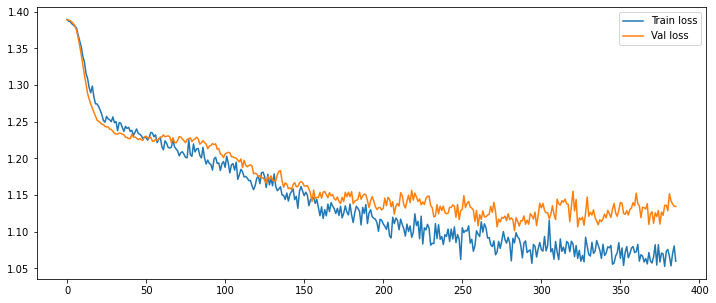

Final results Train:0.710 | Val:0.556 | Test: -0.028


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/676169 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/661666 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

126-10/100) T:1.228 -> 1.253 | V:1.262 (Best: 1.260)
127-11/100) T:1.255 -> 1.238 | V:1.271 (Best: 1.260)
128-12/100) T:1.242 -> 1.238 | V:1.260 (Best: 1.260)
129-13/100) T:1.235 -> 1.250 | V:1.277 (Best: 1.260)
130-14/100) T:1.234 -> 1.228 | V:1.281 (Best: 1.260)
131-15/100) T:1.239 -> 1.244 | V:1.273 (Best: 1.260)
132-16/100) T:1.229 -> 1.234 | V:1.281 (Best: 1.260)
133-17/100) T:1.231 -> 1.231 | V:1.270 (Best: 1.260)
134-18/100) T:1.236 -> 1.254 | V:1.280 (Best: 1.260)
135-19/100) T:1.254 -> 1.236 | V:1.269 (Best: 1.260)
136-20/100) T:1.231 -> 1.240 | V:1.254 (Best: 1.260)
137-0/100) T:1.242 -> 1.261 | V:1.261 (Best: 1.254)
138-1/100) T:1.241 -> 1.241 | V:1.263 (Best: 1.254)
139-2/100) T:1.225 -> 1.240 | V:1.271 (Best: 1.254)
140-3/100) T:1.231 -> 1.254 | V:1.272 (Best: 1.254)
141-4/100) T:1.231 -> 1.235 | V:1.270 (Best: 1.254)
142-5/100) T:1.218 -> 1.259 | V:1.271 (Best: 1.254)
143-6/100) T:1.233 -> 1.242 | V:1.272 (Best: 1.254)
144-7/100) T:1.224 -> 1.238 | V:1.271 (Best: 1.254)
1

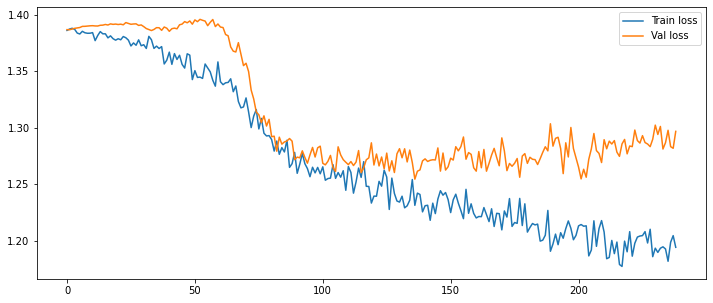

Final results Train:0.474 | Val:0.309 | Test: 0.435


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/659530 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/647775 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

127-12/100) T:1.122 -> 1.122 | V:1.137 (Best: 1.142)
128-0/100) T:1.112 -> 1.103 | V:1.146 (Best: 1.137)
129-1/100) T:1.110 -> 1.121 | V:1.144 (Best: 1.137)
130-2/100) T:1.115 -> 1.122 | V:1.142 (Best: 1.137)
131-3/100) T:1.107 -> 1.107 | V:1.140 (Best: 1.137)
132-4/100) T:1.117 -> 1.125 | V:1.143 (Best: 1.137)
133-5/100) T:1.111 -> 1.113 | V:1.135 (Best: 1.137)
134-0/100) T:1.113 -> 1.106 | V:1.140 (Best: 1.135)
135-1/100) T:1.107 -> 1.103 | V:1.143 (Best: 1.135)
136-2/100) T:1.106 -> 1.106 | V:1.142 (Best: 1.135)
137-3/100) T:1.109 -> 1.104 | V:1.143 (Best: 1.135)
138-4/100) T:1.112 -> 1.108 | V:1.147 (Best: 1.135)
139-5/100) T:1.106 -> 1.099 | V:1.137 (Best: 1.135)
140-6/100) T:1.106 -> 1.111 | V:1.147 (Best: 1.135)
141-7/100) T:1.106 -> 1.110 | V:1.153 (Best: 1.135)
142-8/100) T:1.119 -> 1.101 | V:1.139 (Best: 1.135)
143-9/100) T:1.104 -> 1.098 | V:1.143 (Best: 1.135)
144-10/100) T:1.114 -> 1.102 | V:1.140 (Best: 1.135)
145-11/100) T:1.111 -> 1.109 | V:1.153 (Best: 1.135)
146-12/10

284-30/100) T:1.071 -> 1.050 | V:1.109 (Best: 1.102)
285-31/100) T:1.074 -> 1.063 | V:1.120 (Best: 1.102)
286-32/100) T:1.068 -> 1.062 | V:1.109 (Best: 1.102)
287-33/100) T:1.057 -> 1.058 | V:1.105 (Best: 1.102)
288-34/100) T:1.054 -> 1.040 | V:1.114 (Best: 1.102)
289-35/100) T:1.065 -> 1.069 | V:1.107 (Best: 1.102)
290-36/100) T:1.046 -> 1.058 | V:1.107 (Best: 1.102)
291-37/100) T:1.057 -> 1.057 | V:1.103 (Best: 1.102)
292-38/100) T:1.067 -> 1.045 | V:1.108 (Best: 1.102)
293-39/100) T:1.061 -> 1.048 | V:1.106 (Best: 1.102)
294-40/100) T:1.075 -> 1.050 | V:1.113 (Best: 1.102)
295-41/100) T:1.059 -> 1.054 | V:1.109 (Best: 1.102)
296-42/100) T:1.062 -> 1.049 | V:1.100 (Best: 1.102)
297-0/100) T:1.032 -> 1.067 | V:1.113 (Best: 1.100)
298-1/100) T:1.070 -> 1.045 | V:1.109 (Best: 1.100)
299-2/100) T:1.065 -> 1.044 | V:1.109 (Best: 1.100)
300-3/100) T:1.061 -> 1.059 | V:1.104 (Best: 1.100)
301-4/100) T:1.059 -> 1.053 | V:1.110 (Best: 1.100)
302-5/100) T:1.038 -> 1.046 | V:1.105 (Best: 1.100)

440-59/100) T:1.029 -> 1.020 | V:1.091 (Best: 1.085)
441-60/100) T:1.031 -> 1.030 | V:1.093 (Best: 1.085)
442-61/100) T:1.027 -> 1.010 | V:1.087 (Best: 1.085)
443-62/100) T:1.022 -> 1.038 | V:1.091 (Best: 1.085)
444-63/100) T:1.031 -> 1.023 | V:1.093 (Best: 1.085)
445-64/100) T:1.041 -> 1.018 | V:1.093 (Best: 1.085)
446-65/100) T:1.017 -> 1.027 | V:1.094 (Best: 1.085)
447-66/100) T:1.023 -> 1.030 | V:1.092 (Best: 1.085)
448-67/100) T:1.002 -> 1.035 | V:1.090 (Best: 1.085)
449-68/100) T:1.034 -> 1.035 | V:1.091 (Best: 1.085)
450-69/100) T:1.034 -> 1.033 | V:1.083 (Best: 1.085)
451-0/100) T:1.021 -> 1.016 | V:1.086 (Best: 1.083)
452-1/100) T:1.041 -> 1.010 | V:1.095 (Best: 1.083)
453-2/100) T:1.024 -> 1.020 | V:1.095 (Best: 1.083)
454-3/100) T:1.046 -> 1.023 | V:1.091 (Best: 1.083)
455-4/100) T:1.026 -> 1.011 | V:1.103 (Best: 1.083)
456-5/100) T:1.036 -> 1.036 | V:1.086 (Best: 1.083)
457-6/100) T:1.047 -> 1.013 | V:1.092 (Best: 1.083)
458-7/100) T:1.024 -> 1.019 | V:1.091 (Best: 1.083)
4

596-42/100) T:1.001 -> 1.008 | V:1.086 (Best: 1.076)
597-43/100) T:1.017 -> 0.999 | V:1.110 (Best: 1.076)
598-44/100) T:1.033 -> 1.017 | V:1.088 (Best: 1.076)
599-45/100) T:1.000 -> 1.010 | V:1.086 (Best: 1.076)
600-46/100) T:1.025 -> 1.020 | V:1.096 (Best: 1.076)
601-47/100) T:1.015 -> 1.023 | V:1.087 (Best: 1.076)
602-48/100) T:0.999 -> 1.000 | V:1.089 (Best: 1.076)
603-49/100) T:1.020 -> 1.004 | V:1.094 (Best: 1.076)
604-50/100) T:0.995 -> 1.028 | V:1.084 (Best: 1.076)
605-51/100) T:1.014 -> 0.997 | V:1.082 (Best: 1.076)
606-52/100) T:1.027 -> 0.997 | V:1.090 (Best: 1.076)
607-53/100) T:1.024 -> 1.006 | V:1.091 (Best: 1.076)
608-54/100) T:1.018 -> 1.001 | V:1.084 (Best: 1.076)
609-55/100) T:1.019 -> 1.015 | V:1.086 (Best: 1.076)
610-56/100) T:1.010 -> 1.007 | V:1.083 (Best: 1.076)
611-57/100) T:0.987 -> 1.011 | V:1.082 (Best: 1.076)
612-58/100) T:1.027 -> 1.002 | V:1.084 (Best: 1.076)
613-59/100) T:1.001 -> 0.999 | V:1.085 (Best: 1.076)
614-60/100) T:1.012 -> 0.993 | V:1.081 (Best: 

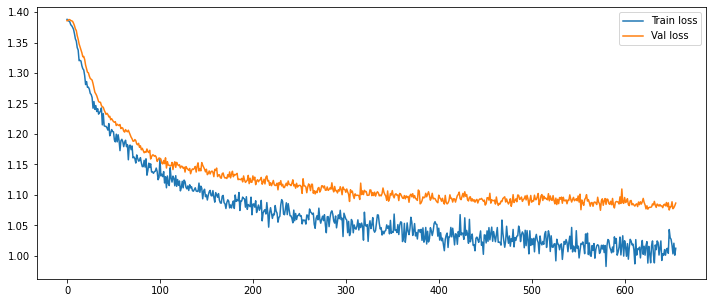

Final results Train:0.776 | Val:0.603 | Test: 0.731


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/599915 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/659047 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

126-8/100) T:1.270 -> 1.278 | V:1.360 (Best: 1.354)
127-9/100) T:1.284 -> 1.261 | V:1.369 (Best: 1.354)
128-10/100) T:1.260 -> 1.278 | V:1.364 (Best: 1.354)
129-11/100) T:1.276 -> 1.264 | V:1.367 (Best: 1.354)
130-12/100) T:1.274 -> 1.291 | V:1.371 (Best: 1.354)
131-13/100) T:1.296 -> 1.286 | V:1.353 (Best: 1.354)
132-14/100) T:1.295 -> 1.281 | V:1.351 (Best: 1.354)
133-0/100) T:1.279 -> 1.291 | V:1.374 (Best: 1.351)
134-1/100) T:1.271 -> 1.259 | V:1.355 (Best: 1.351)
135-2/100) T:1.275 -> 1.270 | V:1.362 (Best: 1.351)
136-3/100) T:1.277 -> 1.240 | V:1.371 (Best: 1.351)
137-4/100) T:1.253 -> 1.271 | V:1.384 (Best: 1.351)
138-5/100) T:1.269 -> 1.276 | V:1.378 (Best: 1.351)
139-6/100) T:1.261 -> 1.251 | V:1.360 (Best: 1.351)
140-7/100) T:1.247 -> 1.263 | V:1.386 (Best: 1.351)
141-8/100) T:1.255 -> 1.260 | V:1.360 (Best: 1.351)
142-9/100) T:1.276 -> 1.263 | V:1.369 (Best: 1.351)
143-10/100) T:1.252 -> 1.265 | V:1.362 (Best: 1.351)
144-11/100) T:1.274 -> 1.265 | V:1.361 (Best: 1.351)
145-1

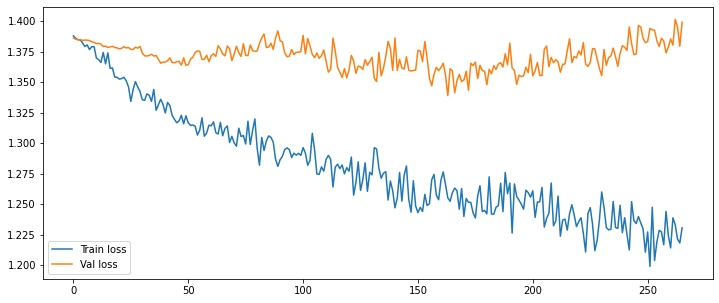

Final results Train:0.394 | Val:0.160 | Test: -0.014


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/685120 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/678863 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

127-0/100) T:1.310 -> 1.315 | V:1.337 (Best: 1.326)
128-1/100) T:1.307 -> 1.289 | V:1.332 (Best: 1.326)
129-2/100) T:1.316 -> 1.305 | V:1.343 (Best: 1.326)
130-3/100) T:1.298 -> 1.294 | V:1.338 (Best: 1.326)
131-4/100) T:1.306 -> 1.305 | V:1.338 (Best: 1.326)
132-5/100) T:1.286 -> 1.301 | V:1.345 (Best: 1.326)
133-6/100) T:1.324 -> 1.286 | V:1.337 (Best: 1.326)
134-7/100) T:1.294 -> 1.311 | V:1.336 (Best: 1.326)
135-8/100) T:1.289 -> 1.279 | V:1.331 (Best: 1.326)
136-9/100) T:1.303 -> 1.287 | V:1.340 (Best: 1.326)
137-10/100) T:1.302 -> 1.289 | V:1.343 (Best: 1.326)
138-11/100) T:1.301 -> 1.298 | V:1.341 (Best: 1.326)
139-12/100) T:1.293 -> 1.296 | V:1.337 (Best: 1.326)
140-13/100) T:1.273 -> 1.288 | V:1.336 (Best: 1.326)
141-14/100) T:1.290 -> 1.273 | V:1.332 (Best: 1.326)
142-15/100) T:1.293 -> 1.299 | V:1.341 (Best: 1.326)
143-16/100) T:1.302 -> 1.308 | V:1.335 (Best: 1.326)
144-17/100) T:1.273 -> 1.290 | V:1.341 (Best: 1.326)
145-18/100) T:1.315 -> 1.312 | V:1.338 (Best: 1.326)
146

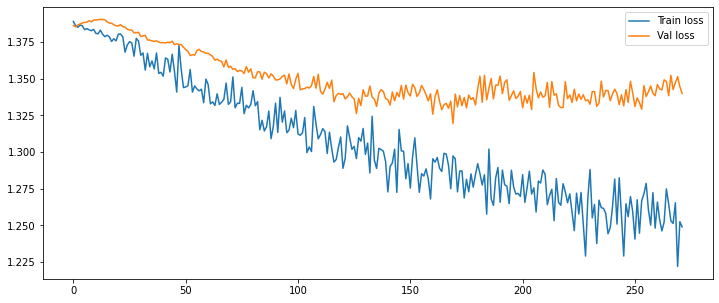

Final results Train:0.279 | Val:0.205 | Test: 0.264


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/677980 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/665373 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

126-19/100) T:1.323 -> 1.340 | V:1.365 (Best: 1.360)
127-20/100) T:1.326 -> 1.324 | V:1.367 (Best: 1.360)
128-21/100) T:1.321 -> 1.323 | V:1.368 (Best: 1.360)
129-22/100) T:1.324 -> 1.324 | V:1.373 (Best: 1.360)
130-23/100) T:1.313 -> 1.321 | V:1.368 (Best: 1.360)
131-24/100) T:1.325 -> 1.319 | V:1.361 (Best: 1.360)
132-25/100) T:1.313 -> 1.311 | V:1.369 (Best: 1.360)
133-26/100) T:1.323 -> 1.319 | V:1.367 (Best: 1.360)
134-27/100) T:1.325 -> 1.303 | V:1.368 (Best: 1.360)
135-28/100) T:1.331 -> 1.320 | V:1.365 (Best: 1.360)
136-29/100) T:1.314 -> 1.321 | V:1.372 (Best: 1.360)
137-30/100) T:1.325 -> 1.334 | V:1.367 (Best: 1.360)
138-31/100) T:1.321 -> 1.332 | V:1.371 (Best: 1.360)
139-32/100) T:1.335 -> 1.315 | V:1.374 (Best: 1.360)
140-33/100) T:1.313 -> 1.335 | V:1.371 (Best: 1.360)
141-34/100) T:1.302 -> 1.327 | V:1.369 (Best: 1.360)
142-35/100) T:1.314 -> 1.317 | V:1.369 (Best: 1.360)
143-36/100) T:1.345 -> 1.307 | V:1.374 (Best: 1.360)
144-37/100) T:1.298 -> 1.327 | V:1.366 (Best: 

282-55/100) T:1.257 -> 1.248 | V:1.358 (Best: 1.346)
283-56/100) T:1.255 -> 1.259 | V:1.359 (Best: 1.346)
284-57/100) T:1.247 -> 1.251 | V:1.355 (Best: 1.346)
285-58/100) T:1.280 -> 1.263 | V:1.368 (Best: 1.346)
286-59/100) T:1.281 -> 1.274 | V:1.362 (Best: 1.346)
287-60/100) T:1.256 -> 1.272 | V:1.374 (Best: 1.346)
288-61/100) T:1.266 -> 1.261 | V:1.352 (Best: 1.346)
289-62/100) T:1.286 -> 1.251 | V:1.380 (Best: 1.346)
290-63/100) T:1.259 -> 1.248 | V:1.363 (Best: 1.346)
291-64/100) T:1.257 -> 1.272 | V:1.371 (Best: 1.346)
292-65/100) T:1.252 -> 1.264 | V:1.359 (Best: 1.346)
293-66/100) T:1.237 -> 1.278 | V:1.382 (Best: 1.346)
294-67/100) T:1.267 -> 1.280 | V:1.364 (Best: 1.346)
295-68/100) T:1.274 -> 1.262 | V:1.362 (Best: 1.346)
296-69/100) T:1.263 -> 1.247 | V:1.358 (Best: 1.346)
297-70/100) T:1.273 -> 1.270 | V:1.368 (Best: 1.346)
298-71/100) T:1.264 -> 1.261 | V:1.358 (Best: 1.346)
299-72/100) T:1.273 -> 1.263 | V:1.365 (Best: 1.346)
300-73/100) T:1.244 -> 1.269 | V:1.349 (Best: 

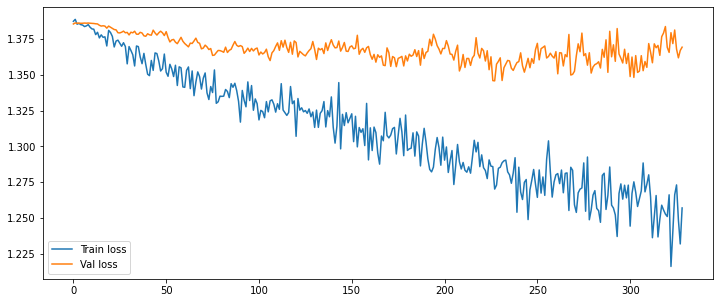

Final results Train:0.263 | Val:0.109 | Test: 0.009


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/680071 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/672135 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

127-0/100) T:1.175 -> 1.167 | V:1.271 (Best: 1.267)
128-1/100) T:1.165 -> 1.170 | V:1.285 (Best: 1.267)
129-2/100) T:1.164 -> 1.173 | V:1.275 (Best: 1.267)
130-3/100) T:1.161 -> 1.161 | V:1.293 (Best: 1.267)
131-4/100) T:1.171 -> 1.170 | V:1.282 (Best: 1.267)
132-5/100) T:1.148 -> 1.165 | V:1.284 (Best: 1.267)
133-6/100) T:1.168 -> 1.167 | V:1.273 (Best: 1.267)
134-7/100) T:1.164 -> 1.174 | V:1.283 (Best: 1.267)
135-8/100) T:1.177 -> 1.160 | V:1.273 (Best: 1.267)
136-9/100) T:1.151 -> 1.164 | V:1.273 (Best: 1.267)
137-10/100) T:1.161 -> 1.171 | V:1.268 (Best: 1.267)
138-11/100) T:1.156 -> 1.168 | V:1.269 (Best: 1.267)
139-12/100) T:1.163 -> 1.161 | V:1.274 (Best: 1.267)
140-13/100) T:1.169 -> 1.157 | V:1.264 (Best: 1.267)
141-0/100) T:1.162 -> 1.166 | V:1.272 (Best: 1.264)
142-1/100) T:1.152 -> 1.145 | V:1.264 (Best: 1.264)
143-2/100) T:1.165 -> 1.168 | V:1.269 (Best: 1.264)
144-3/100) T:1.156 -> 1.155 | V:1.271 (Best: 1.264)
145-4/100) T:1.152 -> 1.148 | V:1.251 (Best: 1.264)
146-0/10

284-15/100) T:1.063 -> 1.046 | V:1.115 (Best: 1.096)
285-16/100) T:1.051 -> 1.045 | V:1.115 (Best: 1.096)
286-17/100) T:1.049 -> 1.045 | V:1.138 (Best: 1.096)
287-18/100) T:1.072 -> 1.043 | V:1.111 (Best: 1.096)
288-19/100) T:1.063 -> 1.064 | V:1.122 (Best: 1.096)
289-20/100) T:1.074 -> 1.053 | V:1.115 (Best: 1.096)
290-21/100) T:1.037 -> 1.041 | V:1.141 (Best: 1.096)
291-22/100) T:1.057 -> 1.068 | V:1.109 (Best: 1.096)
292-23/100) T:1.063 -> 1.039 | V:1.109 (Best: 1.096)
293-24/100) T:1.052 -> 1.035 | V:1.125 (Best: 1.096)
294-25/100) T:1.051 -> 1.027 | V:1.103 (Best: 1.096)
295-26/100) T:1.036 -> 1.021 | V:1.108 (Best: 1.096)
296-27/100) T:1.061 -> 1.042 | V:1.103 (Best: 1.096)
297-28/100) T:1.015 -> 1.067 | V:1.104 (Best: 1.096)
298-29/100) T:1.013 -> 1.057 | V:1.119 (Best: 1.096)
299-30/100) T:1.055 -> 1.032 | V:1.128 (Best: 1.096)
300-31/100) T:1.088 -> 1.069 | V:1.098 (Best: 1.096)
301-32/100) T:1.067 -> 1.031 | V:1.130 (Best: 1.096)
302-33/100) T:1.043 -> 1.054 | V:1.115 (Best: 

440-6/100) T:1.016 -> 1.007 | V:1.077 (Best: 1.054)
441-7/100) T:0.998 -> 0.997 | V:1.078 (Best: 1.054)
442-8/100) T:1.022 -> 0.978 | V:1.077 (Best: 1.054)
443-9/100) T:0.998 -> 1.012 | V:1.078 (Best: 1.054)
444-10/100) T:1.013 -> 0.996 | V:1.067 (Best: 1.054)
445-11/100) T:1.024 -> 1.000 | V:1.082 (Best: 1.054)
446-12/100) T:1.034 -> 1.005 | V:1.062 (Best: 1.054)
447-13/100) T:1.016 -> 1.012 | V:1.080 (Best: 1.054)
448-14/100) T:1.000 -> 1.000 | V:1.058 (Best: 1.054)
449-15/100) T:1.011 -> 0.993 | V:1.078 (Best: 1.054)
450-16/100) T:1.008 -> 1.002 | V:1.059 (Best: 1.054)
451-17/100) T:1.008 -> 1.004 | V:1.068 (Best: 1.054)
452-18/100) T:1.011 -> 1.007 | V:1.072 (Best: 1.054)
453-19/100) T:1.006 -> 0.992 | V:1.085 (Best: 1.054)
454-20/100) T:0.995 -> 0.997 | V:1.107 (Best: 1.054)
455-21/100) T:0.994 -> 0.984 | V:1.079 (Best: 1.054)
456-22/100) T:1.011 -> 1.004 | V:1.109 (Best: 1.054)
457-23/100) T:1.025 -> 1.010 | V:1.080 (Best: 1.054)
458-24/100) T:1.001 -> 0.991 | V:1.090 (Best: 1.05

596-34/100) T:0.993 -> 0.973 | V:1.061 (Best: 1.022)
597-35/100) T:0.971 -> 0.991 | V:1.092 (Best: 1.022)
598-36/100) T:0.988 -> 0.981 | V:1.006 (Best: 1.022)
599-0/100) T:0.965 -> 0.984 | V:1.083 (Best: 1.006)
600-1/100) T:0.993 -> 0.979 | V:1.039 (Best: 1.006)
601-2/100) T:0.973 -> 0.965 | V:1.068 (Best: 1.006)
602-3/100) T:0.978 -> 1.001 | V:1.036 (Best: 1.006)
603-4/100) T:0.979 -> 0.976 | V:1.077 (Best: 1.006)
604-5/100) T:0.990 -> 0.972 | V:1.029 (Best: 1.006)
605-6/100) T:0.978 -> 0.968 | V:1.052 (Best: 1.006)
606-7/100) T:0.989 -> 0.978 | V:1.066 (Best: 1.006)
607-8/100) T:0.970 -> 0.970 | V:1.067 (Best: 1.006)
608-9/100) T:0.980 -> 0.979 | V:1.083 (Best: 1.006)
609-10/100) T:0.975 -> 0.982 | V:1.100 (Best: 1.006)
610-11/100) T:1.008 -> 0.979 | V:1.075 (Best: 1.006)
611-12/100) T:0.961 -> 0.965 | V:1.080 (Best: 1.006)
612-13/100) T:0.987 -> 0.986 | V:1.055 (Best: 1.006)
613-14/100) T:0.973 -> 0.983 | V:1.071 (Best: 1.006)
614-15/100) T:0.974 -> 0.977 | V:1.060 (Best: 1.006)
615

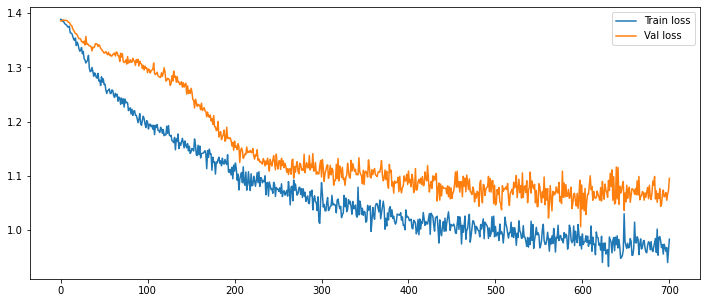

Final results Train:0.827 | Val:0.659 | Test: 0.787


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/674270 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/686792 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

127-0/100) T:1.137 -> 1.120 | V:1.181 (Best: 1.170)
128-1/100) T:1.135 -> 1.129 | V:1.180 (Best: 1.170)
129-2/100) T:1.129 -> 1.126 | V:1.183 (Best: 1.170)
130-3/100) T:1.132 -> 1.118 | V:1.170 (Best: 1.170)
131-4/100) T:1.125 -> 1.131 | V:1.174 (Best: 1.170)
132-5/100) T:1.127 -> 1.127 | V:1.172 (Best: 1.170)
133-6/100) T:1.119 -> 1.112 | V:1.173 (Best: 1.170)
134-7/100) T:1.133 -> 1.135 | V:1.182 (Best: 1.170)
135-8/100) T:1.136 -> 1.127 | V:1.178 (Best: 1.170)
136-9/100) T:1.120 -> 1.118 | V:1.174 (Best: 1.170)
137-10/100) T:1.121 -> 1.126 | V:1.177 (Best: 1.170)
138-11/100) T:1.135 -> 1.130 | V:1.177 (Best: 1.170)
139-12/100) T:1.129 -> 1.114 | V:1.174 (Best: 1.170)
140-13/100) T:1.135 -> 1.127 | V:1.185 (Best: 1.170)
141-14/100) T:1.129 -> 1.130 | V:1.176 (Best: 1.170)
142-15/100) T:1.124 -> 1.120 | V:1.176 (Best: 1.170)
143-16/100) T:1.129 -> 1.124 | V:1.174 (Best: 1.170)
144-17/100) T:1.123 -> 1.107 | V:1.175 (Best: 1.170)
145-18/100) T:1.108 -> 1.130 | V:1.167 (Best: 1.170)
146

283-75/100) T:1.086 -> 1.075 | V:1.155 (Best: 1.149)
284-76/100) T:1.090 -> 1.069 | V:1.155 (Best: 1.149)
285-77/100) T:1.100 -> 1.074 | V:1.170 (Best: 1.149)
286-78/100) T:1.104 -> 1.092 | V:1.161 (Best: 1.149)
287-79/100) T:1.078 -> 1.061 | V:1.169 (Best: 1.149)
288-80/100) T:1.068 -> 1.078 | V:1.162 (Best: 1.149)
289-81/100) T:1.075 -> 1.061 | V:1.159 (Best: 1.149)
290-82/100) T:1.065 -> 1.083 | V:1.158 (Best: 1.149)
291-83/100) T:1.069 -> 1.078 | V:1.170 (Best: 1.149)
292-84/100) T:1.078 -> 1.065 | V:1.162 (Best: 1.149)
293-85/100) T:1.074 -> 1.082 | V:1.167 (Best: 1.149)
294-86/100) T:1.093 -> 1.074 | V:1.156 (Best: 1.149)
295-87/100) T:1.083 -> 1.074 | V:1.158 (Best: 1.149)
296-88/100) T:1.068 -> 1.067 | V:1.154 (Best: 1.149)
297-89/100) T:1.069 -> 1.075 | V:1.161 (Best: 1.149)
298-90/100) T:1.082 -> 1.082 | V:1.166 (Best: 1.149)
299-91/100) T:1.069 -> 1.070 | V:1.173 (Best: 1.149)
300-92/100) T:1.063 -> 1.074 | V:1.155 (Best: 1.149)
301-93/100) T:1.079 -> 1.077 | V:1.155 (Best: 

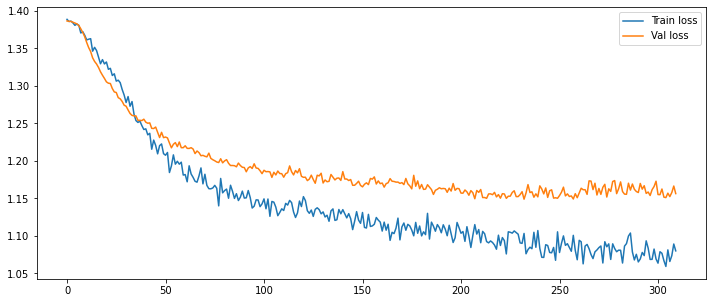

Final results Train:0.631 | Val:0.480 | Test: 0.593


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/672328 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/674098 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 22, 256]             256
       BatchNorm2d-2           [-1, 4, 22, 256]               8
            Conv2d-3            [-1, 8, 1, 256]             176
            Conv2d-4            [-1, 8, 1, 256]             176
       BatchNorm2d-5            [-1, 8, 1, 256]              16
               ELU-6            [-1, 8, 1, 256]               0
         AvgPool2d-7             [-1, 8, 1, 64]               0
           Dropout-8             [-1, 8, 1, 64]               0
            Conv2d-9             [-1, 8, 1, 64]             128
           Conv2d-10             [-1, 8, 1, 64]              64
  SeparableConv2d-11             [-1, 8, 1, 64]               0
      BatchNorm2d-12             [-1, 8, 1, 64]              16
              ELU-13             [-1, 8, 1, 64]               0
        AvgPool2d-14              [-1, 

127-14/100) T:1.072 -> 1.078 | V:1.112 (Best: 1.108)
128-15/100) T:1.063 -> 1.069 | V:1.109 (Best: 1.108)
129-16/100) T:1.082 -> 1.068 | V:1.114 (Best: 1.108)
130-17/100) T:1.071 -> 1.054 | V:1.102 (Best: 1.108)
131-0/100) T:1.061 -> 1.069 | V:1.106 (Best: 1.102)
132-1/100) T:1.080 -> 1.084 | V:1.097 (Best: 1.102)
133-0/100) T:1.064 -> 1.071 | V:1.103 (Best: 1.097)
134-1/100) T:1.059 -> 1.064 | V:1.093 (Best: 1.097)
135-0/100) T:1.071 -> 1.071 | V:1.093 (Best: 1.093)
136-1/100) T:1.089 -> 1.070 | V:1.095 (Best: 1.093)
137-2/100) T:1.073 -> 1.053 | V:1.103 (Best: 1.093)
138-3/100) T:1.068 -> 1.052 | V:1.090 (Best: 1.093)
139-0/100) T:1.064 -> 1.059 | V:1.103 (Best: 1.090)
140-1/100) T:1.056 -> 1.054 | V:1.106 (Best: 1.090)
141-2/100) T:1.075 -> 1.059 | V:1.102 (Best: 1.090)
142-3/100) T:1.060 -> 1.064 | V:1.096 (Best: 1.090)
143-4/100) T:1.066 -> 1.060 | V:1.089 (Best: 1.090)
144-5/100) T:1.057 -> 1.045 | V:1.095 (Best: 1.090)
145-6/100) T:1.043 -> 1.059 | V:1.097 (Best: 1.090)
146-7/10

284-23/100) T:1.020 -> 1.021 | V:1.063 (Best: 1.047)
285-24/100) T:1.012 -> 1.045 | V:1.056 (Best: 1.047)
286-25/100) T:1.031 -> 0.998 | V:1.055 (Best: 1.047)
287-26/100) T:1.028 -> 1.023 | V:1.061 (Best: 1.047)
288-27/100) T:1.011 -> 1.016 | V:1.048 (Best: 1.047)
289-28/100) T:1.006 -> 1.009 | V:1.049 (Best: 1.047)
290-29/100) T:0.992 -> 0.995 | V:1.046 (Best: 1.047)
291-30/100) T:1.030 -> 1.020 | V:1.043 (Best: 1.047)
292-0/100) T:0.997 -> 1.004 | V:1.053 (Best: 1.043)
293-1/100) T:1.012 -> 1.024 | V:1.055 (Best: 1.043)
294-2/100) T:1.005 -> 1.019 | V:1.068 (Best: 1.043)
295-3/100) T:1.004 -> 0.996 | V:1.056 (Best: 1.043)
296-4/100) T:1.010 -> 1.020 | V:1.059 (Best: 1.043)
297-5/100) T:1.011 -> 0.990 | V:1.070 (Best: 1.043)
298-6/100) T:1.000 -> 1.014 | V:1.055 (Best: 1.043)
299-7/100) T:1.011 -> 0.988 | V:1.055 (Best: 1.043)
300-8/100) T:1.012 -> 1.005 | V:1.061 (Best: 1.043)
301-9/100) T:1.017 -> 1.026 | V:1.066 (Best: 1.043)
302-10/100) T:1.011 -> 1.004 | V:1.054 (Best: 1.043)
303

440-35/100) T:0.983 -> 0.998 | V:1.073 (Best: 1.027)
441-36/100) T:0.991 -> 0.989 | V:1.054 (Best: 1.027)
442-37/100) T:0.960 -> 0.983 | V:1.052 (Best: 1.027)
443-38/100) T:0.975 -> 0.976 | V:1.045 (Best: 1.027)
444-39/100) T:0.982 -> 0.991 | V:1.060 (Best: 1.027)
445-40/100) T:0.977 -> 0.988 | V:1.045 (Best: 1.027)
446-41/100) T:0.979 -> 0.969 | V:1.059 (Best: 1.027)
447-42/100) T:0.981 -> 1.002 | V:1.041 (Best: 1.027)
448-43/100) T:1.008 -> 1.015 | V:1.050 (Best: 1.027)
449-44/100) T:0.977 -> 0.982 | V:1.063 (Best: 1.027)
450-45/100) T:0.982 -> 0.981 | V:1.059 (Best: 1.027)
451-46/100) T:0.966 -> 0.989 | V:1.058 (Best: 1.027)
452-47/100) T:0.976 -> 0.982 | V:1.056 (Best: 1.027)
453-48/100) T:0.982 -> 0.987 | V:1.063 (Best: 1.027)
454-49/100) T:0.990 -> 0.998 | V:1.042 (Best: 1.027)
455-50/100) T:1.004 -> 0.978 | V:1.059 (Best: 1.027)
456-51/100) T:0.998 -> 1.000 | V:1.063 (Best: 1.027)
457-52/100) T:0.981 -> 0.981 | V:1.046 (Best: 1.027)
458-53/100) T:0.956 -> 0.991 | V:1.045 (Best: 

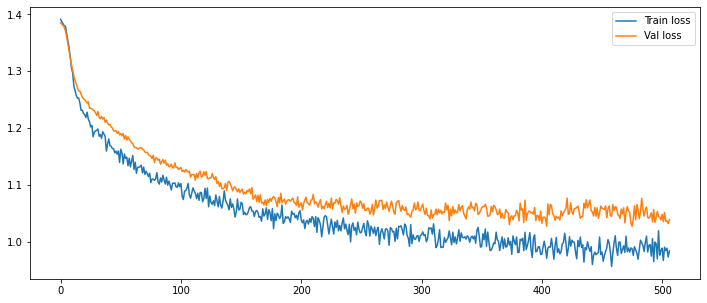

Final results Train:0.777 | Val:0.602 | Test: -0.009


In [69]:
import numpy as np
import mne
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch import nn
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ica_benchmark.processing.ica import get_ica_instance
from copy import deepcopy
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
random_state = 1

mne.set_log_level(0)
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')
# raw_fn = lambda raw: apply_raw(exponential_standardize, raw)
raw_fn = lambda raw: apply_raw(process_raw_fn, raw)

dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)

fold_sizes = None

splitter = Splitter(
    dataset,
    uids=dataset.list_uids(),
#     uids=["8"],
    sessions=dataset.SESSIONS,
    runs=dataset.RUNS,
    load_kwargs=dict(
        reject=False,
        tmin=0.5,
        tmax=2.6,
        raw_fn=raw_fn,
        concatenate=False
    ),
    splitter=KFold(4),
    intra_session_shuffle=False,
    fold_sizes=fold_sizes,
)

filter_kwargs = dict(
    method="fir",
#     iir_params=dict(
#         order=3,
#         ftype="butter"
#     )
)
splits_iterable = splitter.yield_splits_epochs(mode="inter_session")
results = list()
for i, fold_splits in enumerate(splits_iterable):
    
    uid = fold_splits[0]["uid"][0]
    
    train_epochs, test_epochs = splitter.load_from_splits(fold_splits, fold_sizes=None)
    if isinstance(train_epochs, (list, tuple)):
        train_epochs = train_epochs[0].load_data()
        test_epochs = test_epochs[0].load_data()
        
    n_channels = len(train_epochs.ch_names)

    train_data = train_epochs.copy().resample(128).filter(4, 40, **filter_kwargs).get_data()[..., :256]
    test_data = train_epochs.copy().resample(128).filter(4, 40, **filter_kwargs).get_data()[..., :256]
    train_labels = train_epochs.events[:, 2]
    test_labels = test_epochs.events[:, 2]
    
    del train_epochs, test_epochs


    train_data = np.expand_dims(train_data, axis=1)
    test_data = np.expand_dims(test_data, axis=1)
    
    train_data, train_labels = torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).to(dtype=torch.int64)
    test_data, test_labels = torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).to(dtype=torch.int64)
    
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=.25, random_state=random_state)
    
    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_dataloader = DataLoader(train_dataset, batch_size=16)
    
    torch.manual_seed(random_state)
    model = EEGNet(n_channels, 4, 256).float()
    summary(model, input_size=(1, n_channels, 256), device="cpu")
    
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    best_state = None
    best_val_loss = 1000
    patience = 0
    max_patience = 100
    min_delta = 1e-3
    
    train_losses = list()
    val_losses = list()
    for epoch in range(1000):
        
        optim = Adam(model.parameters(), lr=1e-3)
        
        epoch_loss = 0
        epoch_loss_after_norm = 0
        model.train()
        for batch_number, (batch_x, batch_y) in enumerate(train_dataloader):
            optim.zero_grad()
            
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            epoch_loss += loss.item() / len(train_dataloader)

            loss.backward()
            optim.step()
            
            # Projection to norm constraints
            model.apply_constraints()
            
            epoch_loss_after_norm += criterion(model(batch_x), batch_y).item() / len(train_dataloader)

        model.eval()
        val_loss = criterion(
            model(val_data),
            val_labels
        ).item()

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        print("{}-{}/{}) T:{:.3f} -> {:.3f} | V:{:.3f} (Best: {:.3f})".format(epoch, patience, max_patience, epoch_loss, epoch_loss_after_norm, val_loss, best_val_loss))
        
        if (best_val_loss - val_loss) > min_delta:
            best_state = deepcopy(model.state_dict())
            best_val_loss = val_loss
            patience = 0
        elif patience > max_patience:
            break
        else:
            patience += 1
    
    model.load_state_dict(best_state)
    model.eval()
    train_kappa = cohen_kappa_score(
        train_labels,
        (model(train_data) > .5).detach().numpy().argmax(axis=1)
    )
    val_kappa = cohen_kappa_score(
        val_labels,
        (model(val_data) > .5).detach().numpy().argmax(axis=1)
    )
    test_kappa = cohen_kappa_score(
        test_labels,
        (model(test_data) > .5).detach().numpy().argmax(axis=1)
    )
    results.append(
        dict(
            uid=uid,
            train_kappa=train_kappa,
            val_kappa=val_kappa,
            test_kappa=test_kappa,
            
        )
    )
    plt.figure(figsize=(12, 5))
    plt.title(uid)
    plt.plot(range(len(train_losses)), train_losses, label="Train loss")
    plt.plot(range(len(val_losses)), val_losses, label="Val loss")
    plt.legend()
    plt.show()

    print("Final results Train:{:.3f} | Val:{:.3f} | Test: {:.3f}".format(train_kappa, val_kappa, test_kappa))

In [70]:
import pandas as pd

pd.DataFrame.from_records(results)

,uid,train_kappa,val_kappa,test_kappa
0,1,0.709661,0.555670,-0.027778
1,2,0.474121,0.308770,0.435185
2,3,0.775720,0.602908,0.731481
3,4,0.393946,0.159682,-0.013889
4,5,0.279384,0.205047,0.263889
5,6,0.262841,0.108911,0.009259
6,7,0.826859,0.659485,0.787037
7,8,0.631122,0.479691,0.592593
8,9,0.776500,0.601910,-0.009259


In [101]:
from ica_benchmark.split.split import Split
Split([dict(uid="8", session=1, run=1)]).load_epochs(dataset, raw_fn=raw_fn, concatenate=True)


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/674270 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/Documents/GIT/BCI_MsC/ica_benchmark/split/split.py:39: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


ValueError: zero-size array to reduction operation maximum which has no identity

In [17]:
fold_splits[0]["uid"]

['8']

In [100]:
splits_iterable = splitter.yield_splits_epochs(mode="inter_session")
for i, fold_splits in enumerate(splits_iterable):
    print(fold_splits)

[Split({'uid': '8', 'session': 1, 'run': 1}), Split({'uid': '8', 'session': 2, 'run': 1})]


In [142]:

train_acc = cohen_kappa_score(
    train_labels,
    (model(train_data) > .5).detach().numpy().argmax(axis=1)
)
val_acc = cohen_kappa_score(
    val_labels,
    (model(val_data) > .5).detach().numpy().argmax(axis=1)
)
train_acc, val_acc

(0.0, 0.0)

In [ ]:
fold_splits

depthwiseconv2d.weight torch.Size([8, 1, 22, 1])
first_block_top.0.weight torch.Size([4, 1, 1, 64])
first_block_top.1.weight torch.Size([4])
first_block_top.1.bias torch.Size([4])
first_block_bottom.0.weight torch.Size([8])
first_block_bottom.0.bias torch.Size([8])
second_block.0.depthwise_layer.weight torch.Size([16, 1, 1, 16])
second_block.0.pointwise_layer.weight torch.Size([8, 16, 1, 1])
second_block.1.weight torch.Size([8])
second_block.1.bias torch.Size([8])
classifier.1.weight torch.Size([4, 64])
classifier.1.bias torch.Size([4])


In [95]:
splitter.load_kwargs = dict(reject=dict(eeg=800e-6), tmin=0.5, tmax=2.6, raw_fn=raw_fn, concatenate=False)
splitter.load_from_splits(fold_splits, fold_sizes=None)

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/674270 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


  0%|          | 0/686792 [00:00<?, ?it/s]

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


[[<Epochs |  288 events (good & bad), 0.5 - 2.6 sec, baseline off, ~26 kB, data not loaded,
   '0': 72
   '1': 72
   '2': 72
   '3': 72>],
 [<Epochs |  288 events (good & bad), 0.5 - 2.6 sec, baseline off, ~26 kB, data not loaded,
   '0': 72
   '1': 72
   '2': 72
   '3': 72>]]

In [53]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()


In [55]:
input.shape, target.shape, input.dtype, target.dtype

(torch.Size([3, 5]), torch.Size([3]), torch.float32, torch.int64)

In [57]:
pred.shape, batch_y.shape

(torch.Size([4, 4]), torch.Size([4]))

In [61]:
target.to(dtype=torch.int64)

tensor([0, 0, 1])

In [225]:
import numpy as np
from torch.optim import Adam

for i in range(10):
    classes = torch.zeros((100, 3))
    classes[np.arange(100), torch.randint(0, 3, size=(100,))] = 1

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    optimizer.zero_grad()
    model.train()

    r = model.forward(torch.rand(100, 1, 64, 256))
    loss = criterion(
        classes,
        r
    )
    loss.backward()
    optimizer.step()


In [5]:
train_data.shape

(100, 62, 1001)

In [177]:
a = model.first_block_top[-1].weight

print(a[0])
with torch.no_grad():
    a.copy_(a.abs())    
print(a[0])


tensor([[[ 0.0709],
         [ 0.0347],
         [ 0.1205],
         [-0.0972],
         [-0.1152],
         [-0.0761],
         [-0.1074],
         [ 0.0319],
         [ 0.0363],
         [ 0.0700],
         [ 0.0049],
         [-0.0747],
         [ 0.1075],
         [-0.0938],
         [ 0.0251],
         [ 0.0308],
         [-0.1087],
         [ 0.0276],
         [-0.0731],
         [ 0.0515],
         [ 0.1104],
         [ 0.0224],
         [-0.0765],
         [-0.0339],
         [-0.0308],
         [-0.0664],
         [-0.0456],
         [-0.0893],
         [-0.0627],
         [-0.0657],
         [ 0.0852],
         [-0.1182],
         [-0.0798],
         [-0.0899],
         [ 0.0855],
         [ 0.0094],
         [-0.1212],
         [ 0.0163],
         [-0.1208],
         [-0.0929],
         [-0.0332],
         [ 0.0313],
         [ 0.0753],
         [-0.0658],
         [-0.0108],
         [ 0.0987],
         [-0.0683],
         [ 0.0638],
         [-0.0066],
         [ 0.0173],


In [132]:
a.shape

torch.Size([16, 1, 64, 1])

In [106]:
from torchsummary import summary
summary(model, input_size=(1, 64, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        ExpandDims-1           [-1, 1, 64, 256]               0
        ExpandDims-2           [-1, 1, 64, 256]               0
            Conv2d-3           [-1, 8, 64, 256]             520
            Conv2d-4           [-1, 8, 64, 256]             520
       BatchNorm2d-5           [-1, 8, 64, 256]              16
       BatchNorm2d-6           [-1, 8, 64, 256]              16
            Conv2d-7           [-1, 16, 1, 256]           1,040
            Conv2d-8           [-1, 16, 1, 256]           1,040
       BatchNorm2d-9           [-1, 16, 1, 256]              32
      BatchNorm2d-10           [-1, 16, 1, 256]              32
              ELU-11           [-1, 16, 1, 256]               0
              ELU-12           [-1, 16, 1, 256]               0
        AvgPool2d-13            [-1, 16, 1, 64]               0
        AvgPool2d-14            [-1, 16